# Statistical Analysis: Sentiment vs QQQ Returns

This notebook performs deeper analysis on the relationship between sentiment and market returns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load final combined prediction data
combined_df = pd.read_csv('data/combined_data_with_lr.csv')
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Load cleane data
df_truth = pd.read_csv('data/truth_social_cleaned.csv')
df_truth['date'] = pd.to_datetime(df_truth['date'])

print(f"{len(combined_df)} days of market data")
print(f"\n{len(df_truth)} posts")
combined_df.head()

981 days of market data

18778 posts


,Date,Close,High,Low,Open,Volume,Returns,date,post_count,market_post_count,next_day_returns,posts_after_4pm,avg_sentiment,avg_finbert_sentiment,avg_roberta_sentiment,avg_lr_sentiment
0,2022-01-03,392.184052,392.437915,387.497538,389.616221,40575900,NaN,2022-01-03,0.0,0,-1.297050,0,0.0,0.0,0.0,0.0
1,2022-01-04,387.097229,392.769875,383.992413,392.730812,58027200,-1.297050,2022-01-04,0.0,0,-3.072096,0,0.0,0.0,0.0,0.0
2,2022-01-05,375.205231,386.531008,374.951368,385.408170,75739800,-3.072096,2022-01-05,0.0,0,-0.070266,0,0.0,0.0,0.0,0.0
3,2022-01-06,374.941589,378.192883,371.143566,373.379438,70814300,-0.070266,2022-01-06,0.0,0,-1.083299,0,0.0,0.0,0.0,0.0
4,2022-01-07,370.879852,376.640396,369.102901,374.951284,72652300,-1.083299,2022-01-07,0.0,0,0.065836,0,0.0,0.0,0.0,0.0


In [3]:
# Calculate next-day and 2-day returns
combined_df['next_day_returns'] = combined_df['Returns'].shift(-1)
combined_df['two_day_returns'] = combined_df['Returns'].shift(-2)

# Calculate correlations for different time lags
print("Same-Day Correlations")
print(f"VADER: {combined_df['avg_sentiment'].corr(combined_df['Returns']):.4f}")
print(f"FinBERT: {combined_df['avg_finbert_sentiment'].corr(combined_df['Returns']):.4f}")
print(f"RoBERTa: {combined_df['avg_roberta_sentiment'].corr(combined_df['Returns']):.4f}")
print(f"LR: {combined_df['avg_lr_sentiment'].corr(combined_df['Returns']):.4f}")

print("\nNext-Day (t+1) Correlations")
print(f"VADER: {combined_df['avg_sentiment'].corr(combined_df['next_day_returns']):.4f}")
print(f"FinBERT: {combined_df['avg_finbert_sentiment'].corr(combined_df['next_day_returns']):.4f}")
print(f"RoBERTa: {combined_df['avg_roberta_sentiment'].corr(combined_df['next_day_returns']):.4f}")
print(f"LR: {combined_df['avg_lr_sentiment'].corr(combined_df['next_day_returns']):.4f}")

print("\nTwo-Day (t+2) Correlations")
print(f"VADER: {combined_df['avg_sentiment'].corr(combined_df['two_day_returns']):.4f}")
print(f"FinBERT: {combined_df['avg_finbert_sentiment'].corr(combined_df['two_day_returns']):.4f}")
print(f"RoBERTa: {combined_df['avg_roberta_sentiment'].corr(combined_df['two_day_returns']):.4f}")
print(f"LR: {combined_df['avg_lr_sentiment'].corr(combined_df['two_day_returns']):.4f}")

Same-Day Correlations
VADER: 0.0329
FinBERT: -0.0162
RoBERTa: -0.0097
LR: 0.0031

Next-Day (t+1) Correlations
VADER: 0.0167
FinBERT: -0.0327
RoBERTa: -0.0437
LR: 0.0306

Two-Day (t+2) Correlations
VADER: 0.0238
FinBERT: -0.0318
RoBERTa: -0.0075
LR: 0.0350


In [4]:
# Load data with market classification
df_with_market = pd.read_csv('data/truth_social_cleaned.csv')
df_with_market['date'] = pd.to_datetime(df_with_market['date'])

# Check if market classification exists, if not create it
if 'is_market_related' not in df_with_market.columns:
    market_keywords = ['inflation', 'fed', 'economy', 'china', 'stock market', 'tariff', 
                       'trade', 'economic', 'recession', 'gdp', 'unemployment', 'dollar']
    df_with_market['is_market_related'] = df_with_market['cleaned_content'].apply(
        lambda x: any(keyword in str(x).lower() for keyword in market_keywords)
    )

# Load sentiment scores (includes all models)
df_with_sentiment = pd.read_csv('data/truth_social_with_lr.csv')
df_with_market['vader_sentiment'] = df_with_sentiment['vader_sentiment']

# Calculate daily averages for market vs non-market posts
market_daily = df_with_market[df_with_market['is_market_related'] == True].groupby('date')['vader_sentiment'].mean().reset_index(name='market_sentiment')
nonmarket_daily = df_with_market[df_with_market['is_market_related'] == False].groupby('date')['vader_sentiment'].mean().reset_index(name='nonmarket_sentiment')

# Merge with combined data
combined_df = pd.merge(combined_df, market_daily, on='date', how='left')
combined_df = pd.merge(combined_df, nonmarket_daily, on='date', how='left')
combined_df['market_sentiment'] = combined_df['market_sentiment'].fillna(0)
combined_df['nonmarket_sentiment'] = combined_df['nonmarket_sentiment'].fillna(0)

# Compare correlations
print("Market-Related Posts vs Returns")
print(f"Correlation: {combined_df['market_sentiment'].corr(combined_df['Returns']):.4f}")

print("\nNon-Market Posts vs Returns")
print(f"Correlation: {combined_df['nonmarket_sentiment'].corr(combined_df['Returns']):.4f}")

Market-Related Posts vs Returns
Correlation: 0.0046

Non-Market Posts vs Returns
Correlation: 0.0419


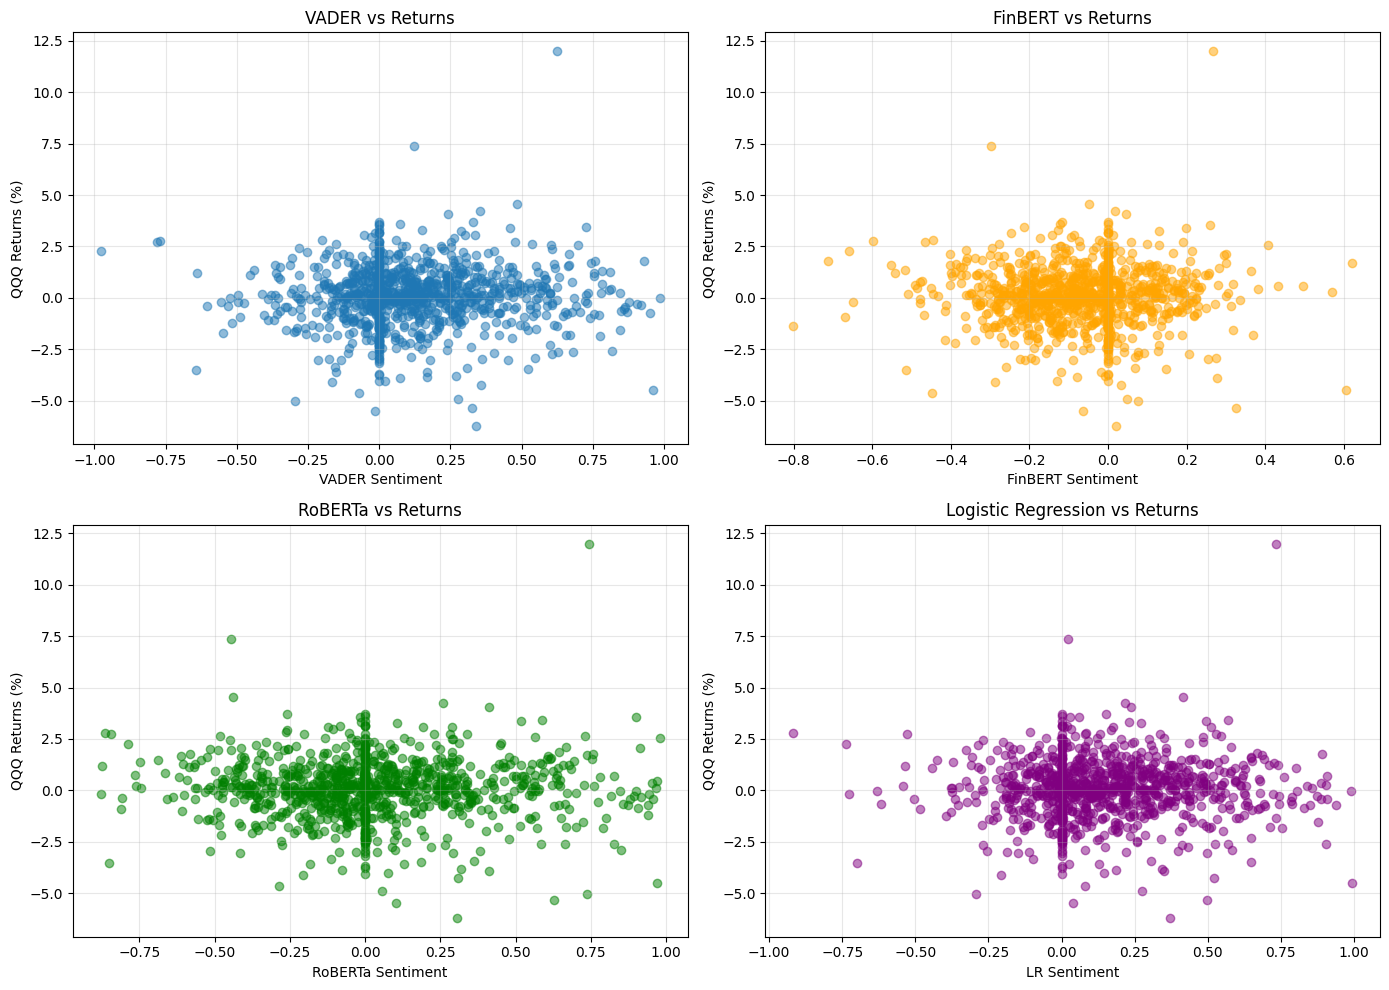

In [5]:
# Plot 1: Sentiment vs Returns (scatter)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].scatter(combined_df['avg_sentiment'], combined_df['Returns'], alpha=0.5)
axes[0,0].set_xlabel('VADER Sentiment')
axes[0,0].set_ylabel('QQQ Returns (%)')
axes[0,0].set_title('VADER vs Returns')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].scatter(combined_df['avg_finbert_sentiment'], combined_df['Returns'], alpha=0.5, color='orange')
axes[0,1].set_xlabel('FinBERT Sentiment')
axes[0,1].set_ylabel('QQQ Returns (%)')
axes[0,1].set_title('FinBERT vs Returns')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].scatter(combined_df['avg_roberta_sentiment'], combined_df['Returns'], alpha=0.5, color='green')
axes[1,0].set_xlabel('RoBERTa Sentiment')
axes[1,0].set_ylabel('QQQ Returns (%)')
axes[1,0].set_title('RoBERTa vs Returns')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].scatter(combined_df['avg_lr_sentiment'], combined_df['Returns'], alpha=0.5, color='purple')
axes[1,1].set_xlabel('LR Sentiment')
axes[1,1].set_ylabel('QQQ Returns (%)')
axes[1,1].set_title('Logistic Regression vs Returns')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

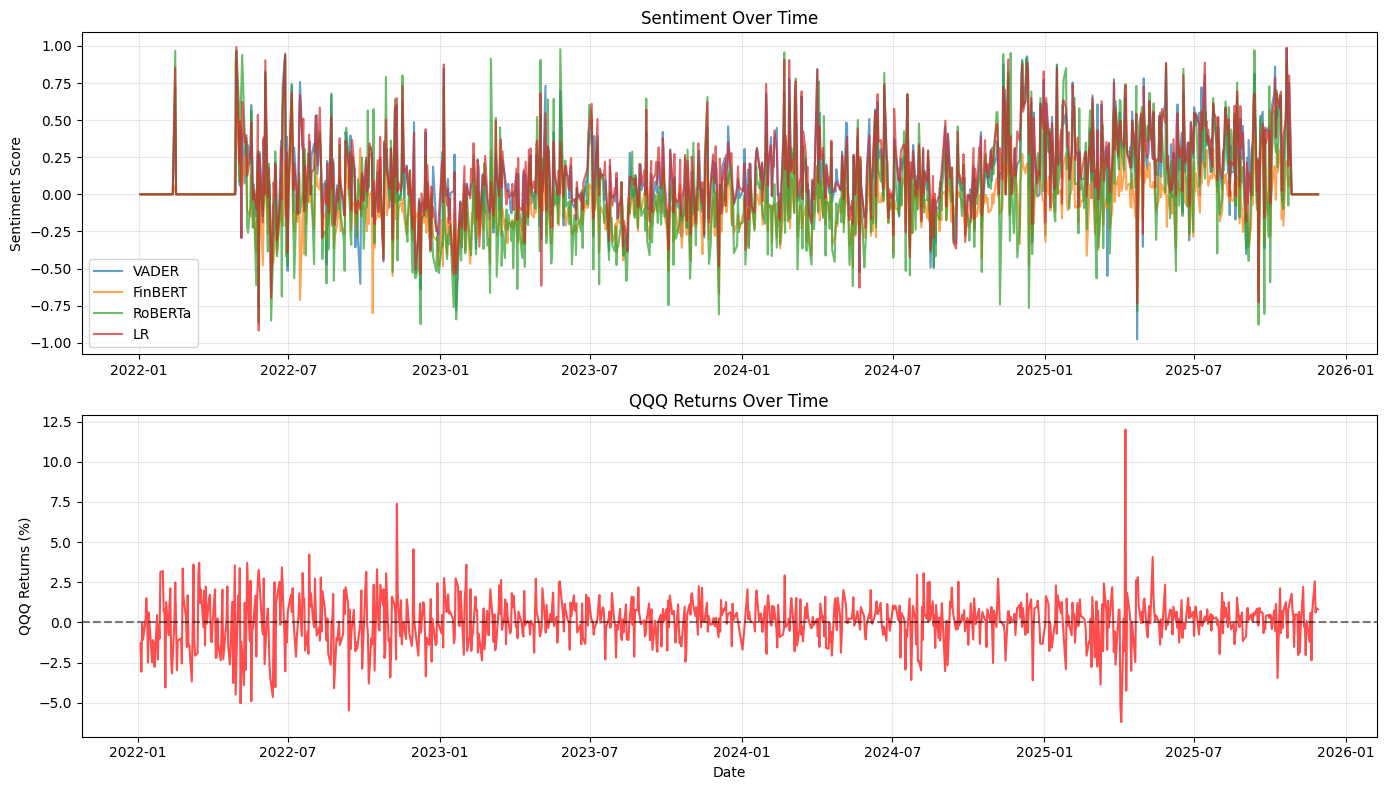

In [6]:
# Plot 2: Time series of sentiment and returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Top: Sentiment over time
ax1.plot(combined_df['date'], combined_df['avg_sentiment'], label='VADER', alpha=0.7)
ax1.plot(combined_df['date'], combined_df['avg_finbert_sentiment'], label='FinBERT', alpha=0.7)
ax1.plot(combined_df['date'], combined_df['avg_roberta_sentiment'], label='RoBERTa', alpha=0.7)
ax1.plot(combined_df['date'], combined_df['avg_lr_sentiment'], label='LR', alpha=0.7)
ax1.set_ylabel('Sentiment Score')
ax1.set_title('Sentiment Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Returns over time
ax2.plot(combined_df['date'], combined_df['Returns'], color='red', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Date')
ax2.set_ylabel('QQQ Returns (%)')
ax2.set_title('QQQ Returns Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Summary Statistics

In [7]:
# Summary of correlations
print("Summary")
print(f"\nSame-Day:")
print(f"  VADER: {combined_df['avg_sentiment'].corr(combined_df['Returns']):.4f}")
print(f"  FinBERT: {combined_df['avg_finbert_sentiment'].corr(combined_df['Returns']):.4f}")
print(f"  RoBERTa: {combined_df['avg_roberta_sentiment'].corr(combined_df['Returns']):.4f}")
print(f"  LR: {combined_df['avg_lr_sentiment'].corr(combined_df['Returns']):.4f}")

print(f"\nNext-Day:")
print(f"  VADER: {combined_df['avg_sentiment'].corr(combined_df['next_day_returns']):.4f}")
print(f"  FinBERT: {combined_df['avg_finbert_sentiment'].corr(combined_df['next_day_returns']):.4f}")
print(f"  RoBERTa: {combined_df['avg_roberta_sentiment'].corr(combined_df['next_day_returns']):.4f}")
print(f"  LR: {combined_df['avg_lr_sentiment'].corr(combined_df['next_day_returns']):.4f}")

print(f"\nMarket vs Non-Market:")
print(f"  Market-related: {combined_df['market_sentiment'].corr(combined_df['Returns']):.4f}")
print(f"  Non-market: {combined_df['nonmarket_sentiment'].corr(combined_df['Returns']):.4f}")

Summary

Same-Day:
  VADER: 0.0329
  FinBERT: -0.0162
  RoBERTa: -0.0097
  LR: 0.0031

Next-Day:
  VADER: 0.0167
  FinBERT: -0.0327
  RoBERTa: -0.0437
  LR: 0.0306

Market vs Non-Market:
  Market-related: 0.0046
  Non-market: 0.0419
